# <a name="0">Machine Learning Accelerator - Computer Vision - Lecture 2</a>


## Fine-Tuning with Pre-trained AlexNet 

In this notebook, we use a pre-trained [AlexNet](https://d2l.ai/chapter_convolutional-modern/alexnet.html) on the [MINC](http://opensurfaces.cs.cornell.edu/publications/minc/)  dataset. This notebook is similar to our previous notebook `MLA-CV-Lecture1-CNN.ipynb`, so we may skip some details to be concise. We will cover the following topics:

1. <a href="#1">Loading and Transforming Dataset</a>      
2. <a href="#2">Fine-tuning Pretrained AlexNet</a>
3. <a href="#3">Testing and Visualizations</a>


First, let's update torch at least to v1.6.0 and d2l to v0.15.0

In [1]:
! pip install -q nvidia-ml-py3==7.352.0
! pip install -q torch==1.8.0
! pip install -q torchvision==0.9.0
! pip install -q d2l==0.16.0
! pip install -q numpy==1.19.5

Now let's import the necessary libraries.

In [2]:
import os
from d2l import torch as d2l
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim import SGD
from torchvision.models import alexnet

## 1. <a name="1">Loading and Transforming Dataset</a>
(<a href="#0">Go to top</a>)

To load the dataset properly, we need to massage the image data a bit by some `transforms` functions. PyTorch provides a full list of [transforms functions](https://pytorch.org/vision/stable/transforms.html) to enable a wide variety of data augmentation. 

We will process some simple data transformations in this example. First, we load the image data and resize it to the given size (224,224). Next, we convert the image tensor of shape (H x W x C) in the range [0, 255] to a float32 tensor of shape (C x H x W) in the range (0, 1) using the `ToTensor` class. Last, we normalize the tensor of shape (C x H x W) with its mean and standard deviation by `Normalize`.

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,0,0), std=(1,1,1))
])

Now apply the predefined transform functions and load the train, validation and test sets.

In practice, reading data can be a significant performance bottleneck, especially when our model is simple or when our computer is fast. To make our life easier when reading from the datasets, we use a `DataLoader` of Gluon, which reads a minibatch of data with size `batch_size` each time.

In [4]:
batch_size = 16

path = '../../data/minc-2500'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

train_loader = DataLoader(
    ImageFolder(train_path, transform=transform),
    batch_size=batch_size, shuffle=True)

validation_loader = DataLoader(
    ImageFolder(val_path, transform=transform),
    batch_size=batch_size, shuffle=False)

test_loader = DataLoader(
    ImageFolder(test_path, transform=transform),
    batch_size=batch_size, shuffle=False)

## 2. <a name="2">Fine-tuning Pretrained AlexNet</a>
(<a href="#0">Go to top</a>)

To fine-tune a pretrained model:
1. We get a pretrained Alexnet from `torchvision.models`. For more models, refer to [Torchvision Models](https://pytorch.org/vision/stable/models.html).
2. The original Alexnet was trained for 1000 categories. We need to change the last layer with a dense layer that has the same number of classes for our problem.
3. Initialize that last layer with [Xavier initialization](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#xavier-initialization)

In [5]:
def fine_tune_alexnet(classes, device):
    """
    Finetune AlexNet 
    classes: number of the output classes 
    device: training context (CPU or GPU)
    """
    finetune_net = alexnet(pretrained=True).to(device)

    num_ftrs = finetune_net.classifier[6].in_features
    finetune_net.classifier[6] = nn.Linear(num_ftrs, classes)

    return finetune_net

Let's create a `net` using the `fine_tune_alexnet()` on available GPUs (or CPUs) by defining the training context `ctx`. Since the MINC dataset has 6 categories, the output classes will be 6.

In [6]:
# Use GPU resource if available, otherwise wil use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_outputs = 6        # 6 output classes
net = fine_tune_alexnet(num_outputs, device)
# Let's print the model. The last layer is classifier[6]
print(net)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Next, we set up the hyperparameters for training, such as the learning rate of optimization algorithms. With the defined learning rate, we are able to create an `Optimizer` to infer the neural network "how to optimize its weights".

In [7]:
learning_rate = 0.001

optimizer = SGD(net.parameters(), lr=learning_rate)

Besides, we need to specify the loss function. Since this problem is a multiclass classification task, we will use softmax as our loss funciton.

In [8]:
criterion = nn.CrossEntropyLoss()

Our network is almost ready to be finetuned! One last thing before the finetuning is to define the `calculate_accuracy` function for evulating our model.

In [9]:
def calculate_accuracy(output, label):
    """Calculate the accuracy of the trained network. 
    output: (batch_size, num_output) float32 tensor
    label: (batch_size, ) int32 tensor """
    
    return (output.argmax(axis=1) == label.float()).float().mean()

Now it's the training time! Starting with the outer loop, we will have 10 epochs (10 full pass through our dataset). Within the inner loop, we yield each mini-batch from the `train_loader`, and update the weights based on the average statistics of this mini-batch.

In [10]:
epochs = 10

for epoch in range(epochs):
    net = net.to(device)
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    net.train() # Activate training mode (dropouts etc.)
    for data, label in train_loader:
        # zero the parameter gradients
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        output = net(data)
        loss = criterion(output, label)
        loss.backward()
        train_acc += calculate_accuracy(output, label).item()
        train_loss += loss.item()
        optimizer.step()
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    net.eval() # Activate "evaluate" mode (don't use dropouts etc.)
    with torch.no_grad():
        for data, label in validation_loader:
            data = data.to(device)
            label = label.to(device)
            output = net(data)
            valid_acc += calculate_accuracy(output, label).item()
            val_loss += criterion(output, label).item()
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch+1, train_loss, train_acc, val_loss, valid_acc))

Epoch 1: train loss 1.111, train acc 0.610, val loss 0.711, val acc 0.833
Epoch 2: train loss 0.618, train acc 0.791, val loss 0.574, val acc 0.865
Epoch 3: train loss 0.493, train acc 0.833, val loss 0.526, val acc 0.859
Epoch 4: train loss 0.428, train acc 0.851, val loss 0.506, val acc 0.875
Epoch 5: train loss 0.371, train acc 0.874, val loss 0.462, val acc 0.880
Epoch 6: train loss 0.332, train acc 0.888, val loss 0.458, val acc 0.896
Epoch 7: train loss 0.290, train acc 0.900, val loss 0.455, val acc 0.880
Epoch 8: train loss 0.270, train acc 0.913, val loss 0.441, val acc 0.906
Epoch 9: train loss 0.236, train acc 0.918, val loss 0.440, val acc 0.901
Epoch 10: train loss 0.234, train acc 0.919, val loss 0.444, val acc 0.885


## 3. <a name="3">Testing and Visualizations</a>
(<a href="#0">Go to top</a>)

Let's validate our model predictions. Meanwhile, we use the `show_images` function and show the sample images and its prediction together.

In [11]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.permute(1,2,0).numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

tensor([0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0], device='cuda:0')


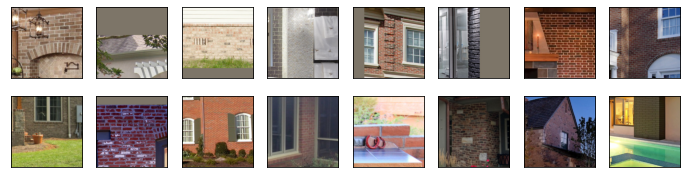

In [12]:
random_test_dataset = ImageFolder(test_path,
                                  transform=transform)
random_test_sample = DataLoader(random_test_dataset,
                                batch_size=2*8, shuffle=False)

net.eval() # Activate eval mode (don't use dropouts etc.)
for data, label in random_test_sample:
    show_images(data, 2, 8);
    data = data.to(device)
    pred = net(data)
    print(pred.argmax(axis=1))
    break